# Data Preprocessing

This notebook is intended to process data in the "downloaded" folder into tensorized form, particularly aqs and meteorology data.

## 1. Join AQ and Met datasets

In [2]:
import pandas as pd
import json
import os
import numpy as np

PARAM_DICT = {
    "44201": "o3",
    "68105": "avg_temp",
    "62101": "outdoor_temp",
    "61301": "mix_height",
    "42101": "co",
    "42601": "no",
    "42602": "no2",
    "88101": "pm25",
    "86101": "pm10_25"
}

In [ ]:
# === Get AQS data ===

# import requests, json, tqdm
# for year in tqdm.tqdm(range(1998,2026)):
#     r = requests.get(
#         url='https://aqs.epa.gov/data/api/sampleData/bySite',
#         params={
#             'email':'david_mike_woodilla@brown.edu',
#             'key':'berrycat37',
#             'param':",".join(PARAM_DICT.keys()),
#             'bdate':f'{year}0101',
#             'edate':f'{year}1231',
#             'state':'44',
#             'county':'007',
#             'site':'1010'
#         }
#     )
#     with open(f'./data/downloaded/aqs/myron{year}.json', 'w') as f:
#         json.dump(r.json(), f, indent=2)

100%|██████████| 28/28 [08:38<00:00, 18.52s/it]


In [3]:
df_list:list[pd.DataFrame] = []

for dataset in os.listdir("./data/downloaded/aqs/"):
    if "json" not in dataset: continue
    with open(os.path.join("./data/downloaded/aqs/", dataset)) as f:
        raw_json = json.load(f)
    df = pd.json_normalize(raw_json['Data'])
    df['datetime_gmt'] = pd.to_datetime(df['date_gmt'] + ' ' + df['time_gmt'], utc=True)

    df = df[['datetime_gmt','parameter_code','sample_measurement']]
    df['parameter_code'] = df['parameter_code'].apply(lambda x: PARAM_DICT[x])
    df = df.pivot_table(
        index='datetime_gmt',
        columns='parameter_code',
        values='sample_measurement',
        dropna=False
    ).reset_index()
    df = df.drop(columns=['avg_temp','mix_height', 'pm10_25'], errors='ignore')
    df_list.extend([df])

aq_ds_primary = pd.concat(df_list)
aq_ds_primary['datetime_gmt'] = pd.to_datetime(aq_ds_primary['datetime_gmt'], utc=True, errors='raise')
aq_ds_primary = aq_ds_primary.set_index('datetime_gmt')
aq_ds_primary.to_pickle('./data/downloaded/myron_ds.pkl')
aq_ds_primary.to_json('./data/downloaded/myron_ds.json', index=True)

In [4]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

worldmet = importr("worldmet")

ro.r('''
	met_ds = worldmet::importNOAA(code=c("725070-14765"), year=1998:2025)
''')

met_ds_primary:pd.DataFrame
with (ro.default_converter + pandas2ri.converter).context():
    met_ds_primary = ro.r['met_ds'] # type: ignore

 ■■                                 4% |  ETA:  1m
 ■■■                                7% |  ETA:  1m
 ■■■■                              11% |  ETA:  1m
 ■■■■■                             14% |  ETA:  1m
 ■■■■■■                            18% |  ETA:  1m
 ■■■■■■■                           21% |  ETA:  1m
 ■■■■■■■■■                         25% |  ETA:  1m
 ■■■■■■■■■■                        29% |  ETA: 47s
 ■■■■■■■■■■■                       32% |  ETA: 44s
 ■■■■■■■■■■■■                      36% |  ETA: 42s
 ■■■■■■■■■■■■■                     39% |  ETA: 39s
 ■■■■■■■■■■■■■■                    43% |  ETA: 37s
 ■■■■■■■■■■■■■■■                   46% |  ETA: 35s
 ■■■■■■■■■■■■■■■■                  50% |  ETA: 34s
 ■■■■■■■■■■■■■■■■■                 54% |  ETA: 31s
 ■■■■■■■■■■■■■■■■■■                57% |  ETA: 29s
 ■■■■■■■■■■■■■■■■■■■               61% |  ETA: 26s
 ■■■■■■■■■■■■■■■■■■■■              64% |  ETA: 24s
 ■■■■■■■■■■■■■■■■■■■■■             68% |  ETA: 21s
 ■■■■■■■■■■■■■■■■■■■■■■        

In [5]:
met_ds = met_ds_primary
aq_ds  = aq_ds_primary
met_ds = met_ds.rename(columns={"date":"datetime"})
met_ds = met_ds.reset_index()
aq_ds  = aq_ds.reset_index()
aq_ds  = aq_ds .rename(columns={"datetime_gmt":"datetime"})

met_ds = met_ds.drop(
    columns=[
        'cl_2','cl_3','cl_2_height','cl_3_height','precip_6','pwc',
        'code','station','latitude','longitude','elev','ws','wd','index', 'air_temp',
        'atmos_pres','visibility', 'cl','cl_1','cl_1_height'
    ]
)
met_ds = met_ds.rename(
    columns={
        "Uu":"ws_east_west",
        "Vv":"ws_north_south"
    }
)

met_ds['datetime'] = pd.to_datetime(met_ds['datetime'], utc=True)
aq_ds['datetime']  = pd.to_datetime(aq_ds['datetime'], utc=True)
ds = pd.merge_ordered(
    met_ds,
    aq_ds,
    on='datetime'
)

ds.to_json("data/preprocessed/joined_met_aq_ds.json", indent=2, index=True)
ds.to_pickle("data/preprocessed/joined_met_aq_ds.pkl")

## 2. Tensorize joined dataset

Convert dataset from pd.DataFrame to tf.Tensor; split and encode datetime information using sinusoidal function; process missing data. As side effect, pickle dataset tensor to disk.

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf

ds = pd.read_pickle('./data/preprocessed/joined_met_aq_ds.pkl')

In [31]:
# === Normalize parameters ===

'''
Robust scaling (x - median)/(IQR) is used with intent of increasing model generalizability.
'''

ds = ds.set_index('datetime')
ds = ds.rename(columns={
    'ws_east_west':'wind_x',
    'ws_north_south':'wind_y',
    'outdoor_temp':'aq_temp'
})

iqr = ds.quantile(0.75)-ds.quantile(0.25)
median_normed = ds - ds.median()
ds.describe().to_json("./data/preprocessed/normalizing_constants.json")

ds = median_normed.div(iqr, axis='columns')

In [32]:
# === Add temporal positional encodings ===

datetime = pd.to_datetime(ds.index, utc=True)
ds['Weekday'] = datetime.weekday # These will be one-hot encoded later

unix_ts = datetime.map(pd.Timestamp.timestamp)
normed_dt = (unix_ts - unix_ts[0])/3600

encode_time = lambda f,x: f( ((2*np.pi)/x) * normed_dt )

ds['Day Sine'] = encode_time(np.sin, 24)
ds['Day Cosine'] = encode_time(np.cos, 24)
ds['Month Sine'] = encode_time(np.sin, datetime.daysinmonth * 24)
ds['Month Cosine'] = encode_time(np.cos, datetime.daysinmonth * 24)
ds['Year Sine'] = encode_time(np.sin, 24*365)
ds['Year Cosine'] = encode_time(np.cos, 24*365)



# pd.to_pickle(ds, './data/aqs_dataset.pkl')

In [33]:
# print(ds.columns)

# Reorder cols
ds = ds[[
    'Day Sine', 'Day Cosine', 
    'Month Sine', 'Month Cosine',
    'Year Sine', 'Year Cosine',
    'Weekday',
    'aq_temp','dew_point', 
    'RH', 'ceil_hgt', 
    'wind_x', 'wind_y',
    'co', 'no', 'no2', 'o3', 'pm25'
]]



In [35]:
ds_np = ds.to_numpy()[:,1:]

ds_tf = tf.data.Dataset.from_tensor_slices((ds_np[:,:12], ds_np[:,12:]))

ds_tf.save("./data/myron_tfg_dataset")

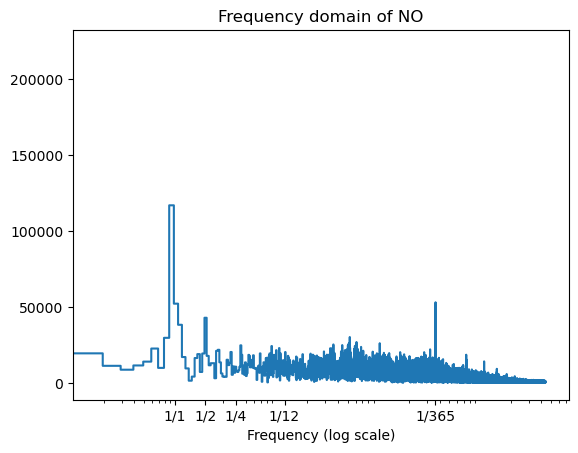

In [ ]:
# import matplotlib.pyplot as plt

# param = 'no'

# series = ds[param]
# series.dropna(inplace=True)

# fft = tf.signal.rfft(series)
# f_per_ds = np.arange(0, len(fft))
# n_samples_hours = len(series)
# hours_per_yr = 24*365.2524
# years_per_dataset = n_samples_hours/(hours_per_yr)
# f_per_year = f_per_ds / years_per_dataset

# plt.title(f"Frequency domain of {param.upper()}")
# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
# # plt.ylim(0, 200000)
# plt.xlim([0.1, max(plt.xlim())])
# plt.xticks([1,2,4, 12, 365.2524], labels=['1/1', '1/2', '1/4', '1/12', '1/365'])
# _ = plt.xlabel('Frequency (log scale)')